In [9]:
#Today:
#nLeptons plot is weird -- now better before cuts?

#WZ background vs WZZ, mT for WZ, the remaining lepton from WZZ after indexing (i.e. identification for the invariant mass), the W candidate lepton! -- understand better

#scale the x axis better
#find the normalization factor for ZZ -- done
#Fiducial cross section is the one after the cuts
#el_eta plot weird after delR cut
#WZ number after the cuts, number bad. #Figure out why WZ number so bad after the ==3 cut.
#Add features, have a good story, also for the >=4lep - simple variables like sum of transverse momenta for jet and lepton
#Z candidate mass
#Leading sub leading second leading lepton momentum. 

#plot sub leading and third leading distributions before after cut


#sub leading lepton plots, 

#If time allows, do the same for 4leps, 
#Engineered variables would be different for >=4 case

# Data Loading and Preprocessing

In [1]:
#File Load Resetter
import importlib
import features_and_functions  # or whatever your .py file is named
importlib.reload(features_and_functions)

<module 'features_and_functions' from '/users/dbhandari/WZZtest/features_and_functions.py'>

In [2]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vector 
import numpy as np
import copy
import pandas as pd
import sys
sys.path.append('.')  #this adds current directory to path if not already
from features_and_functions import delta_r, invariant_mass, compute_invariant_mass_5lep, mt_nonZ_lepton_MET, compute_delta_phi_Z_lep
from features_and_functions import transverse_mass, compute_event_shapes, compute_mt, compute_deltaR_5lep, z_met_balance_features
from features_and_functions import compute_best_z_candidate_masses, extract_features_5lep, clean_leptons, compute_delta_phi_Z_MET
from features_and_functions import compute_thrust, compute_event_shapes_exact, total_event_et, compute_best_z_candidate_pt, compute_triplet_masses_5lep
from features_and_functions import compute_pairwise_masses_5lep, compute_delta_eta_phi_5lep, compute_pt_5lepsys, compute_dphi_met_5lepsys
import features_and_functions
print(dir(features_and_functions))

sns.set(style="whitegrid")

branches = [
    'el_pt', 'el_phi', 'el_eta', 'el_charge', 'nElectrons',
    'mu_pt', 'mu_phi', 'mu_eta', 'mu_charge', 'nMuons',
    'jet_pt', 'jet_phi', 'jet_eta', 'jet_mass', 'nJets',
    'jet_btag', 'MET', 'MET_Phi'
]

#loaading files
#wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WH_HToZZ_pythia8_events.root"
wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root"

wzz_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root"
background_files = [
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
]

#Or in a better way:
file_paths = {
    "WH": "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root",
    "WZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root",
    "WZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "ZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
}


def load_tree(file_path, branches):
    with uproot.open(file_path) as f:
        if file_path == wh_file:
            tree = f["PolarizationTree"]
        else:
            tree = f["LowPtSUSY_Tree"]
        return tree.arrays(branches, library="ak")

#loading signal and background data
signal_data = {
    "WH": load_tree(wh_file, branches),
    "WZZ": load_tree(wzz_file, branches),
}

background_data = {
    "WZ": load_tree(background_files[0], branches),
    "ZZ": load_tree(background_files[1], branches),
}

#need output directory for plots
output_dir = "plots_normalized"
os.makedirs(output_dir, exist_ok=True)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'ak', 'behavior', 'clean_leptons', 'compute_4lep_masses_5lep', 'compute_best_z_candidate_masses', 'compute_best_z_candidate_masses_4lep', 'compute_best_z_candidate_pt', 'compute_deltaR_3lep', 'compute_deltaR_4lep', 'compute_deltaR_5lep', 'compute_delta_eta_phi_3lep', 'compute_delta_eta_phi_4lep', 'compute_delta_eta_phi_5lep', 'compute_delta_phi_Z_MET', 'compute_delta_phi_Z_lep', 'compute_delta_phi_between_Zs', 'compute_dphi_met_3lepsys', 'compute_dphi_met_4lepsys', 'compute_dphi_met_5lepsys', 'compute_event_shapes', 'compute_event_shapes_exact', 'compute_invariant_mass_3lep', 'compute_invariant_mass_4lep', 'compute_invariant_mass_5lep', 'compute_mt', 'compute_mt_4l', 'compute_mt_5l', 'compute_pairwise_masses_3lep', 'compute_pairwise_masses_4lep', 'compute_pairwise_masses_5lep', 'compute_pt_3lepsys', 'compute_pt_4lepsys', 'compute_pt_5lepsys', 'compute_thrust', 'compute_triplet_mas

## Making normalized plots of variables

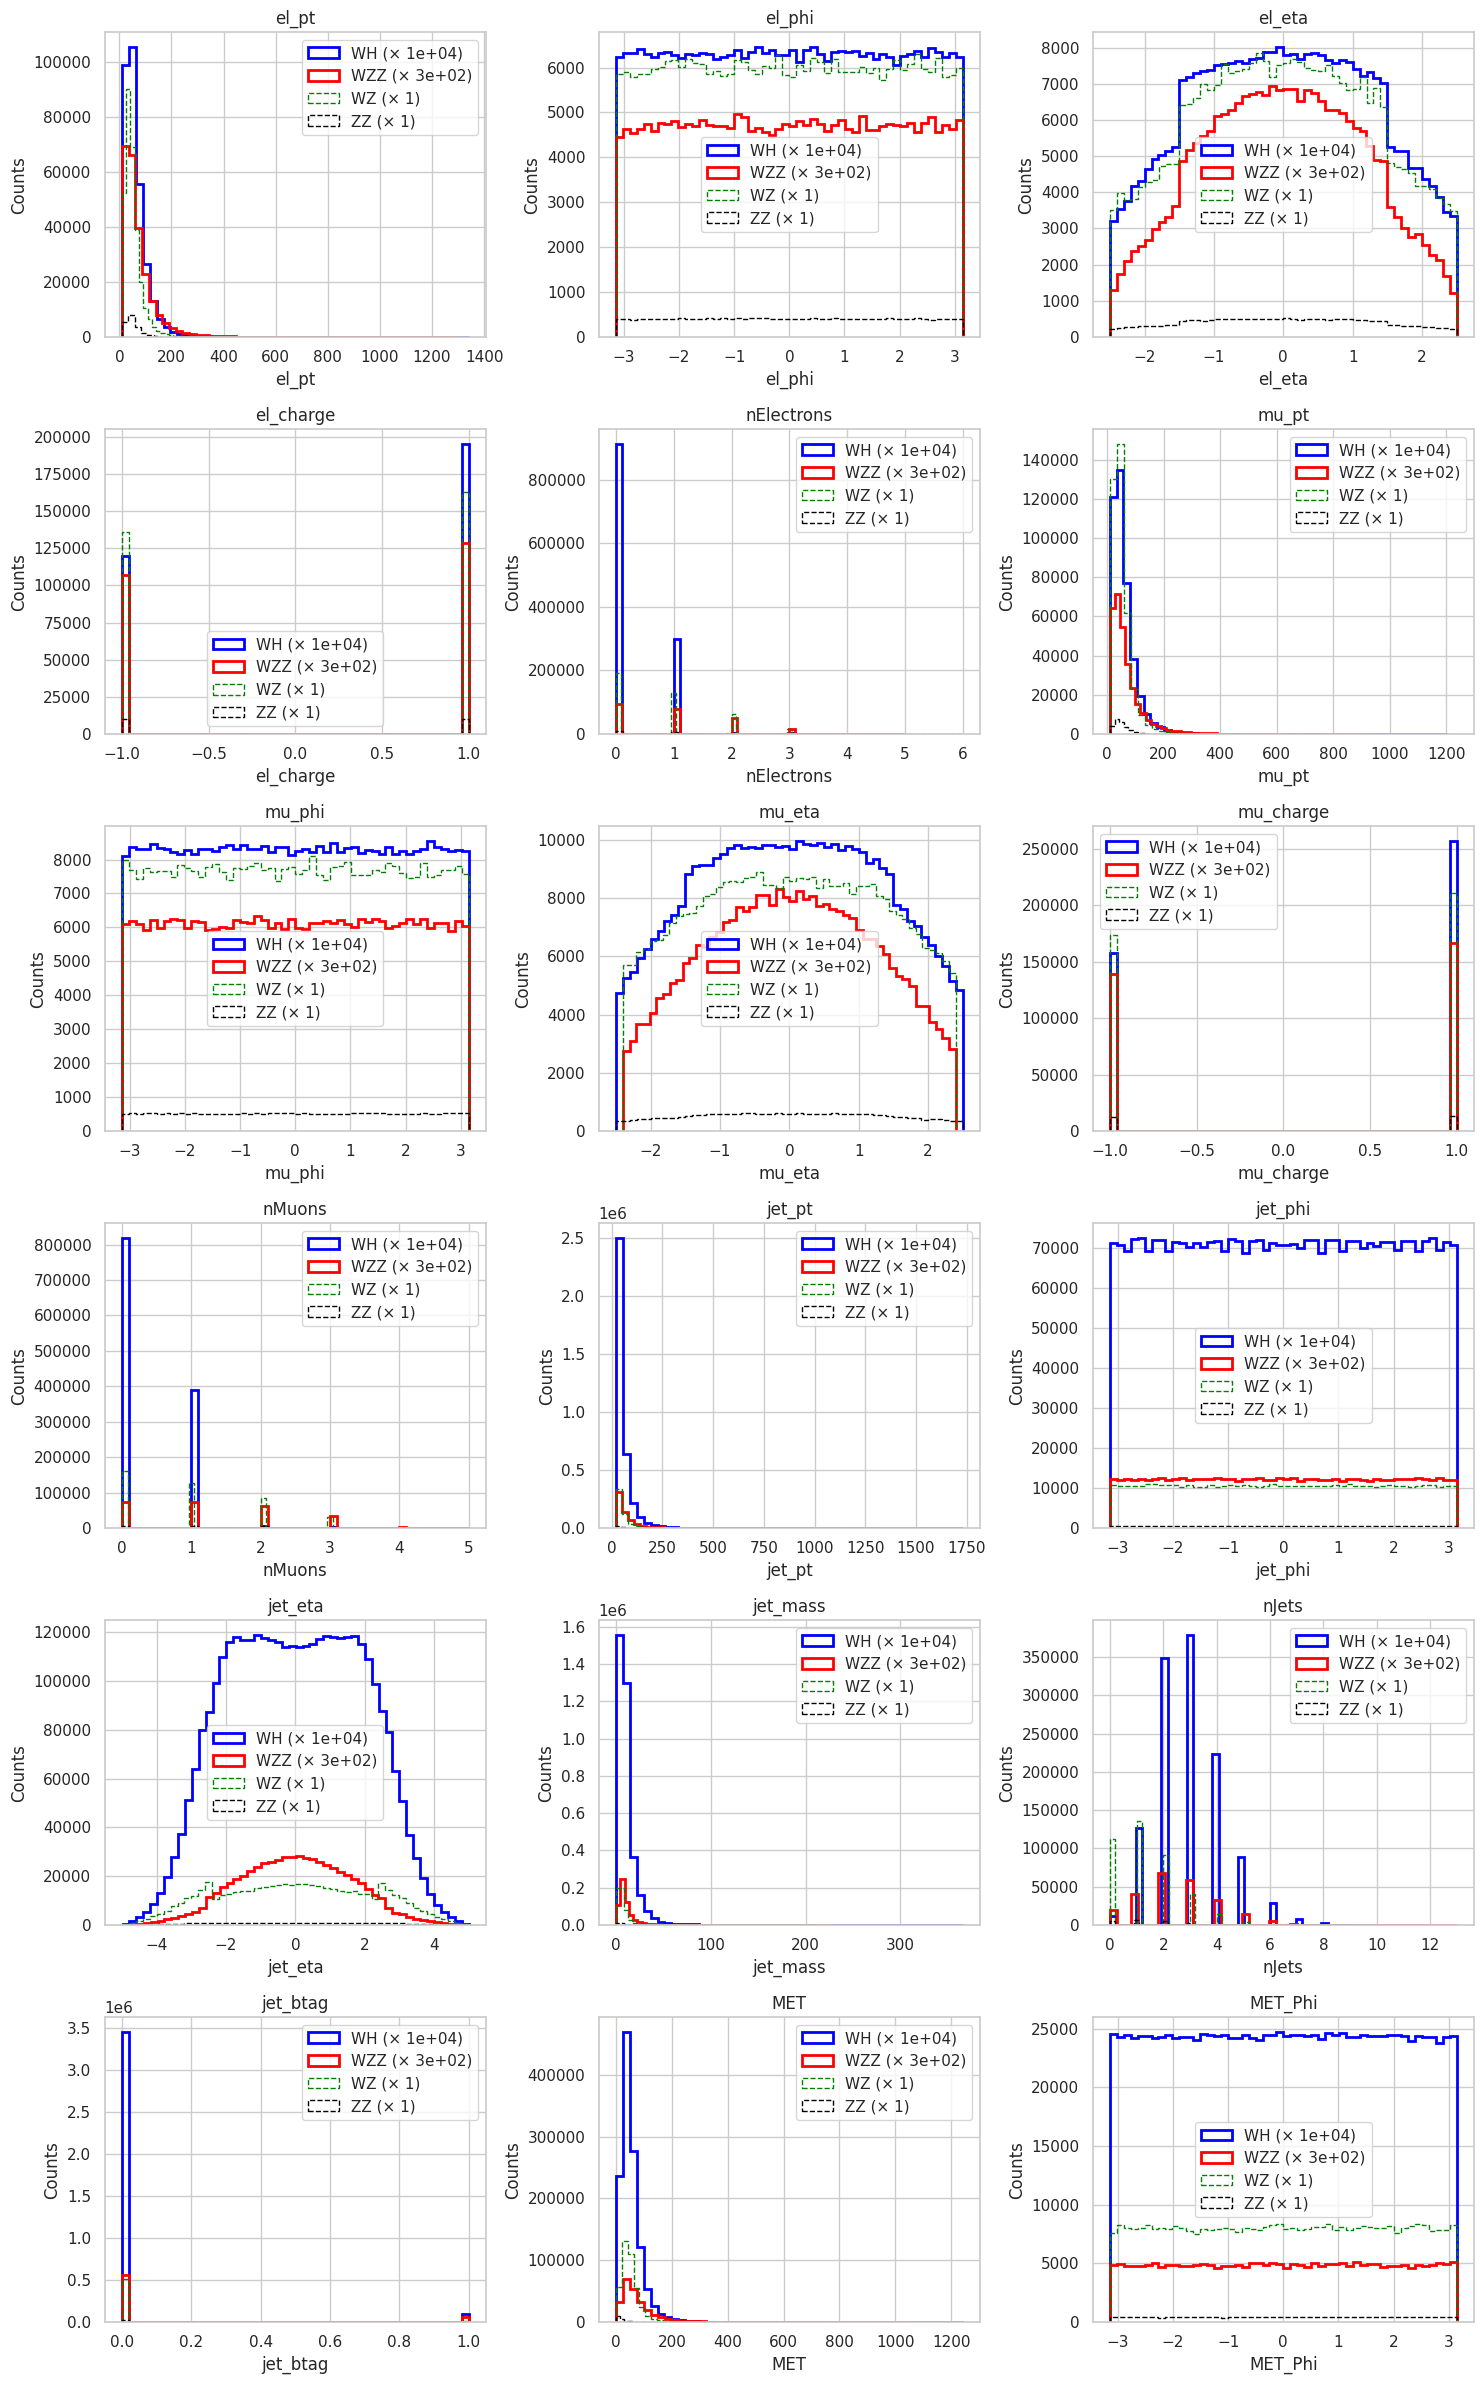

In [12]:
signal_colors = {
    "WH": "blue",
    "WZZ": "red",
}                                  #defining only once for sanity
background_colors = {
    "WZ": "green",
    "ZZ": "black",
}
all_colors = {**signal_colors, **background_colors}

norm_factors = {
    "WH": 0.0001218 * 10000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196   #Why 4? New value used
}

multiplicative_factors = {
    "WH": 10000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()

for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()

#if statements within the plotter can easily scale the x axis for specific plots

for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized.png")
plt.show()

## Leading lepton features

In [5]:
vars_to_print = ['el_pt', 'mu_pt']
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(signal_data["WH"][var][:10]) 
    print("for WZZ:")
    print(signal_data["WZZ"][var][:10])
    print("for WZ:")
    print(background_data["WZ"][var][:10])
    print("for ZZ:")
    print(background_data["ZZ"][var][:10])
     #first 10 entries for each file
    print()

#looks like they're sorted out for each event already,
# For leading particles, we can sort and take the first one
def leading_particle(arr):
    if len(arr) == 0:
        return None
    sorted_arr = ak.sort(arr, ascending=False)
    return sorted_arr[0] if len(sorted_arr) > 0 else None   

#printing leading particles,            #This will print the leading particle ONLY FOR THE FIRST EVENT, NOT USEFUL FOR ALL EVENTS
# we could modify it to print the leading particle for each event
print("Leading particles:")
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(leading_particle(signal_data["WH"][var]))
    print("for WZZ:")
    print(leading_particle(signal_data["WZZ"][var]))
    print("for WZ:")
    print(leading_particle(background_data["WZ"][var]))
    print("for ZZ:")
    print(leading_particle(background_data["ZZ"][var]))
    print()

def get_leading(values):
    try:
        return ak.to_numpy(ak.firsts(values))
    except Exception:
        return ak.to_numpy(values)



el_pt:
for WH:
[[49.9], [], [], [21.3], [], [], [51.5], [], [], []]
for WZZ:
[[], [], [], [], ..., [406], [89.2, 55.5, 30.3], [66.2], [56.6, 35.1, 28.6]]
for WZ:
[[84.6, 23.1], [114, 94.3], [], [], ..., [], [53.2, 37.6], [], [90.4, 22.8]]
for ZZ:
[[], [20.3], [], [], ..., [57.9, 13.8], [107, 27.2], [99.1, 59.9, 38.9, 34.7]]

mu_pt:
for WH:
[[], [], [], [], [], [20.3], [], [38.2], [], []]
for WZZ:
[[63.4], [93.5, 43.2, 40.4], [76.8], [268], [], [44.9], [25], [], [], []]
for WZ:
[[76.4], [], [20.1], [], [], [58], [58.2], [], [17.8], []]
for ZZ:
[[85.9], [87.9, 81], [26.3], [], [47.5, 42.8, ..., 21.5], ..., [], [], [], []]

Leading particles:
el_pt:
for WH:
[49.9]
for WZZ:
[]
for WZ:
[84.6, 23.1]
for ZZ:
[]

mu_pt:
for WH:
[]
for WZZ:
[63.4]
for WZ:
[76.4]
for ZZ:
[85.9]



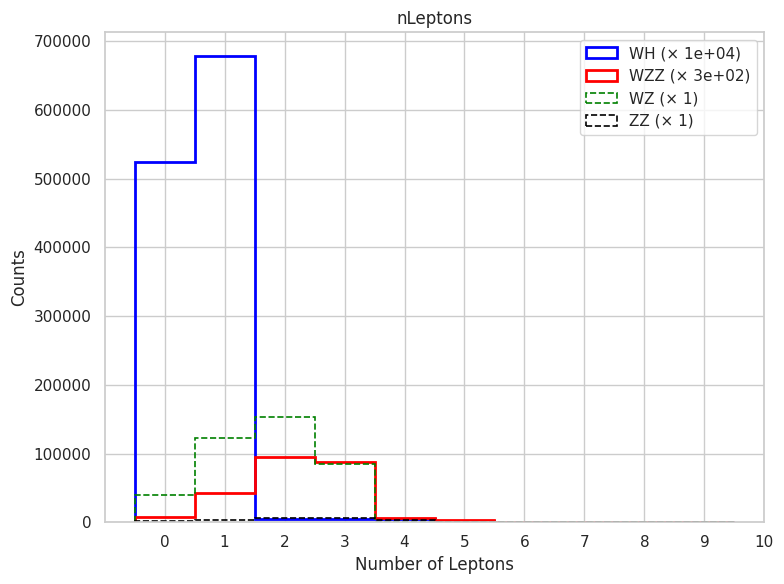

In [6]:
# Colors and factors from Part I
lepton_counts = {}

# Count leptons for signals
for label, arr in signal_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)

# Count leptons for backgrounds
for label, arr in background_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)
    
plt.figure(figsize=(8, 6))
bins = np.arange(0, 10 + 1) - 0.5  # center bins on integer values

for label, nlep in lepton_counts.items():
    weight = norm_factors[label]
    multiplier = multiplicative_factors[label]
    display_label = f"{label} (× {multiplier:.2g})"

    if label in signal_colors:
        color = signal_colors[label]
        linestyle = '-'
        linewidth = 2
    else:
        color = background_colors[label]
        linestyle = '--'
        linewidth = 1.2

    plt.hist(
        nlep,
        bins=bins,
        alpha=1,
        label=display_label,
        histtype='step',
        color=color,
        linewidth=linewidth,
        linestyle=linestyle,
        weights=[weight] * len(nlep)
    )

plt.xlabel("Number of Leptons")
plt.ylabel("Counts")
plt.title("nLeptons")
plt.xticks(np.arange(0, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("nLeptons_normalized.png")
plt.show()


#Why does WH fall off after 1? 

### Plotting del_R before applying any cut

Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


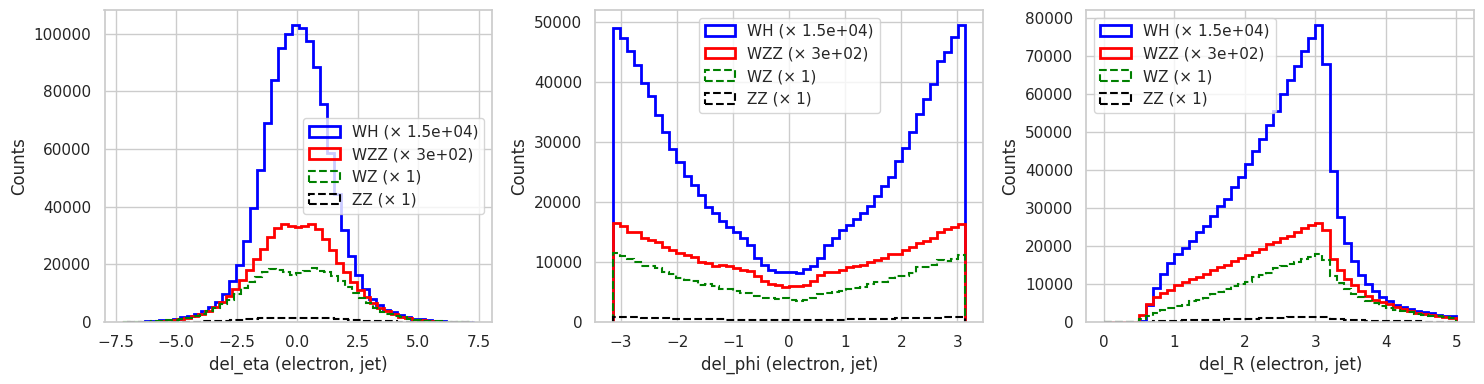

In [7]:
# label mapping for your files (adjust keys to match file_paths keys)
label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

# Normalization factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

# plotting containers for all datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# function to compute delta phi wrapped to [-pi, pi]
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all files and plot
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # zip electron and jet into convenient objects
    events["el"] = ak.zip({"eta": events.el_eta, "phi": events.el_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all el-jet pairs
    el_jet_pairs = ak.cartesian({"el": events.el, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_el_jet = el_jet_pairs["el"].eta - el_jet_pairs["jet"].eta
    delta_phi_el_jet = delta_phi(el_jet_pairs["el"].phi, el_jet_pairs["jet"].phi)
    deltaR_el_jet = np.sqrt(delta_eta_el_jet**2 + delta_phi_el_jet**2)

    # flatten to 1D
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_el_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_el_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_el_jet, axis=None))

    # style + weight
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot all three histograms
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# label axes
axes[0].set_xlabel(r"del_eta (electron, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (electron, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (electron, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


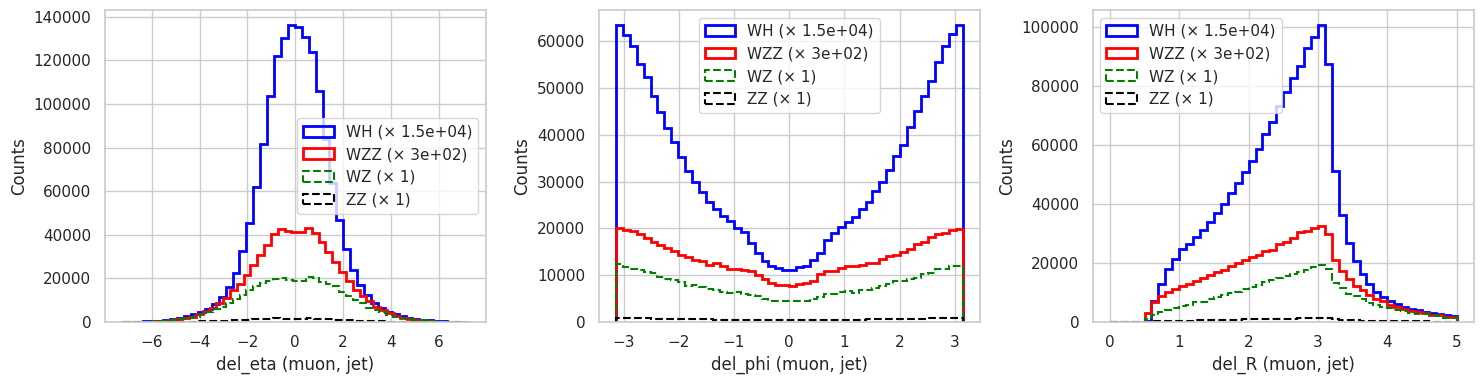

In [8]:
# label mapping
label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

#normaliz factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

# prepare plotting canvas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# delta phi helper
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all datasets
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # muon and jet objects
    events["mu"] = ak.zip({"eta": events.mu_eta, "phi": events.mu_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all muon–jet pairs
    mu_jet_pairs = ak.cartesian({"mu": events.mu, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_mu_jet = mu_jet_pairs["mu"].eta - mu_jet_pairs["jet"].eta
    delta_phi_mu_jet = delta_phi(mu_jet_pairs["mu"].phi, mu_jet_pairs["jet"].phi)
    deltaR_mu_jet = np.sqrt(delta_eta_mu_jet**2 + delta_phi_mu_jet**2)

    # flatten to 1D arrays
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_mu_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_mu_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_mu_jet, axis=None))

    # style + weights
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# axis labels and formatting
axes[0].set_xlabel(r"del_eta (muon, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (muon, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (muon, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Calling Features and Functions, to implement selection cuts and construct features for NN

In [3]:
all_datasets = {
    "WH": signal_data["WH"],
    "WZZ": signal_data["WZZ"],
    "WZ": background_data["WZ"],
    "ZZ": background_data["ZZ"],
}

vector.register_awkward()   #tells vector to automatically interpret awkward arrays of dictionaries

 cuts filter events, so they must be applied while the data is still in the awkward.Array format — before converting to flat pandas DataFrames.

What the nLeptons == 3 cut is doing here:
- counts the total number of leptons before any qualitative cuts (like delR cleaning, pt > 10, |eta| < 2.5).
- selects events that appear to have exactly 3 leptons (muons + electrons).

### Main looper over files that a. implements cuts b. gets a df


In [4]:
dfs = []
label_map = {"WH": 0, "WZZ": 1, "WZ": 2, "ZZ": 3}
lepton_counts = {}

norm_factors = {
    "WH": 0.0001218,
    "WZZ": 0.0081,
    "WZ": 4.0,
    "ZZ": 0.196   
}

for key, path in file_paths.items():
    print(f"Loading {key}...")
    
    events = load_tree(path, branches)

    #aapplying the full cleaning (includes kinematics + delR)
    events_cut = clean_leptons(events, deltaR_cut=0.4, pt_min=10, eta_max=2.5)
    
    nElectrons = ak.num(events_cut.el_pt, axis=1)
    nMuons = ak.num(events_cut.mu_pt, axis=1)     #counter for leptons
    nLeptons = nElectrons + nMuons
    lepton_counts[key] = nLeptons

    events_cut = events_cut[nLeptons >= 5] #require exactly 5 leps

    #Extracting features ONLY AFTER MAKING THE CUTS AHA! 5 leptons 
    df = extract_features_5lep(events_cut, label_map[key])
    df.dropna(inplace=True)
    
    weighted_events = df.shape[0] * norm_factors[key]
    print(f"{df.shape[0]} raw events, {weighted_events:.3f} weighted events")

    dfs.append(df)

Loading WH...
228 raw events, 0.028 weighted events
Loading WZZ...
266 raw events, 2.155 weighted events
Loading WZ...
1 raw events, 4.000 weighted events
Loading ZZ...
2 raw events, 0.392 weighted events


In [5]:
print(dfs)

[         el_pt_0    el_eta_0    el_phi_0     mu_pt_0  mu_eta_0  mu_phi_0  \
9    -999.000000 -999.000000 -999.000000  149.272934 -1.710134  2.850216   
14   -999.000000 -999.000000 -999.000000   88.864998  2.407470  3.091513   
15     43.870403    1.017172   -2.824484  100.643547 -0.530073 -0.013901   
23    131.979263    0.860156   -2.167458   96.739914  1.465275  0.794034   
24   -999.000000 -999.000000 -999.000000   68.026146 -2.280265 -1.177897   
...          ...         ...         ...         ...       ...       ...   
1600 -999.000000 -999.000000 -999.000000   72.333839  0.604175  1.122295   
1613   52.831673    2.100564   -1.546912   65.674049  1.452992  2.262747   
1616   41.053810   -0.645428    0.425364   72.880302  0.448083 -1.966267   
1617   43.647903   -1.936998   -2.696779   43.570801 -2.483978 -2.761967   
1637 -999.000000 -999.000000 -999.000000   54.751839  0.462073  0.002574   

         el_pt_1    el_eta_1    el_phi_1     mu_pt_1  ...  deltaR13  deltaR14  \
9    

In [7]:
print(df[["m_5lep", "total_event_et",
          "pt_5lepsys", "dphi_met_5lepsys", "m12", "m13", "m14", "m15", "m23", "m24", "m25", "m34", "m35", "m45", 
          "deltaR12","deltaR13", "deltaR14", "deltaR15","deltaR23","deltaR24","deltaR25", "deltaR34", "deltaR35", "deltaR45",
          "deta12", "deta13","deta14","deta15", "deta23","deta24", "deta25","deta34", "deta35","deta45",
          "dphi12","dphi13", "dphi14", "dphi15","dphi23", "dphi24", "dphi25","dphi34", "dphi35", "dphi45"]].isna().sum())
             #"MT_lep_MET", "best_Z_mass_mu", "best_Z_mass_el", "best_Z_pt_mu", "best_Z_pt_el", "del_phi_Z_MET_el",

m_5lep              0
total_event_et      0
pt_5lepsys          0
dphi_met_5lepsys    0
m12                 0
m13                 0
m14                 0
m15                 0
m23                 0
m24                 0
m25                 0
m34                 0
m35                 0
m45                 0
deltaR12            0
deltaR13            0
deltaR14            0
deltaR15            0
deltaR23            0
deltaR24            0
deltaR25            0
deltaR34            0
deltaR35            0
deltaR45            0
deta12              0
deta13              0
deta14              0
deta15              0
deta23              0
deta24              0
deta25              0
deta34              0
deta35              0
deta45              0
dphi12              0
dphi13              0
dphi14              0
dphi15              0
dphi23              0
dphi24              0
dphi25              0
dphi34              0
dphi35              0
dphi45              0
dtype: int64


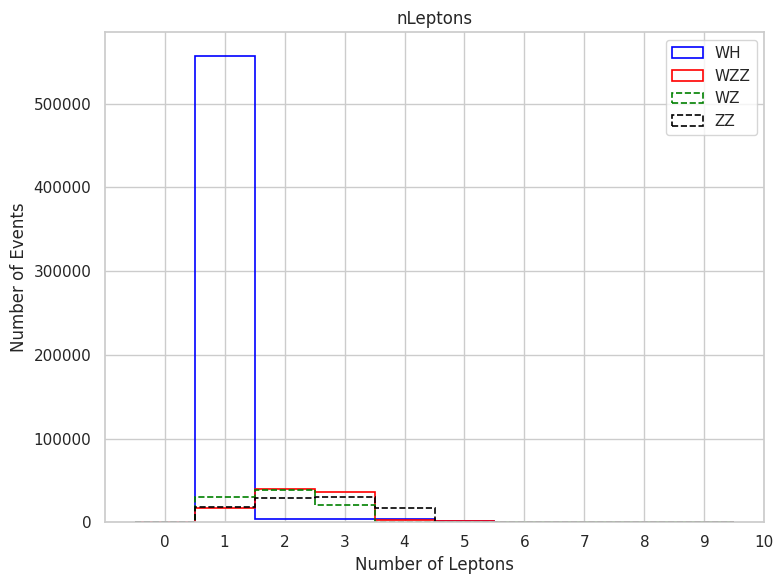

In [7]:
signal_colors = {
    "WH": "blue",
    "WZZ": "red",
}

background_colors = {
    "WZ": "green",
    "ZZ": "black",
}

plt.figure(figsize=(8, 6))
bins = np.arange(0, 10 + 1) - 0.5  #Center on integer values

for key, nlep in lepton_counts.items():
    if key in signal_colors:
        color = signal_colors[key]
        linestyle = '-'
    else:
        color = background_colors.get(key, 'gray')
        linestyle = '--'
    
    plt.hist(nlep, bins=bins, alpha=1, label=key, histtype='step',
         color=color, linewidth=1.2, linestyle=linestyle)


plt.xlabel("Number of Leptons")
plt.ylabel("Number of Events")
plt.title("nLeptons")
plt.xticks(np.arange(0, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
type(dfs)
print(len(dfs))
print(type(dfs[0]))
print(dfs[0].columns)

4
<class 'pandas.core.frame.DataFrame'>
Index(['el_pt_0', 'el_eta_0', 'el_phi_0', 'mu_pt_0', 'mu_eta_0', 'mu_phi_0',
       'el_pt_1', 'el_eta_1', 'el_phi_1', 'mu_pt_1', 'mu_eta_1', 'mu_phi_1',
       'el_pt_2', 'el_eta_2', 'el_phi_2', 'mu_pt_2', 'mu_eta_2', 'mu_phi_2',
       'el_pt_3', 'el_eta_3', 'el_phi_3', 'mu_pt_3', 'mu_eta_3', 'mu_phi_3',
       'el_pt_4', 'el_eta_4', 'el_phi_4', 'mu_pt_4', 'mu_eta_4', 'mu_phi_4',
       'jet_pt_0', 'jet_eta_0', 'jet_phi_0', 'jet_pt_1', 'jet_eta_1',
       'jet_phi_1', 'jet_mass_0', 'jet_btag_0', 'MET', 'MET_Phi', 'm_5lep',
       'total_event_et', 'pt_5lepsys', 'dphi_met_5lepsys', 'm12', 'm13', 'm14',
       'm15', 'm23', 'm24', 'm25', 'm34', 'm35', 'm45', 'm123', 'm124', 'm125',
       'm134', 'm135', 'm145', 'm234', 'm235', 'm245', 'm345', 'm1234',
       'm1235', 'm1245', 'm1345', 'm2345', 'deta12', 'deta13', 'deta14',
       'deta15', 'deta23', 'deta24', 'deta25', 'deta34', 'deta35', 'deta45',
       'dphi12', 'dphi13', 'dphi14', 'dphi15', 

dfs is a list of 4 DataFrames (one per class). Each individual item in dfs (like dfs[0], dfs[1], ...) is a proper pandas DataFrame and includes a label column already.

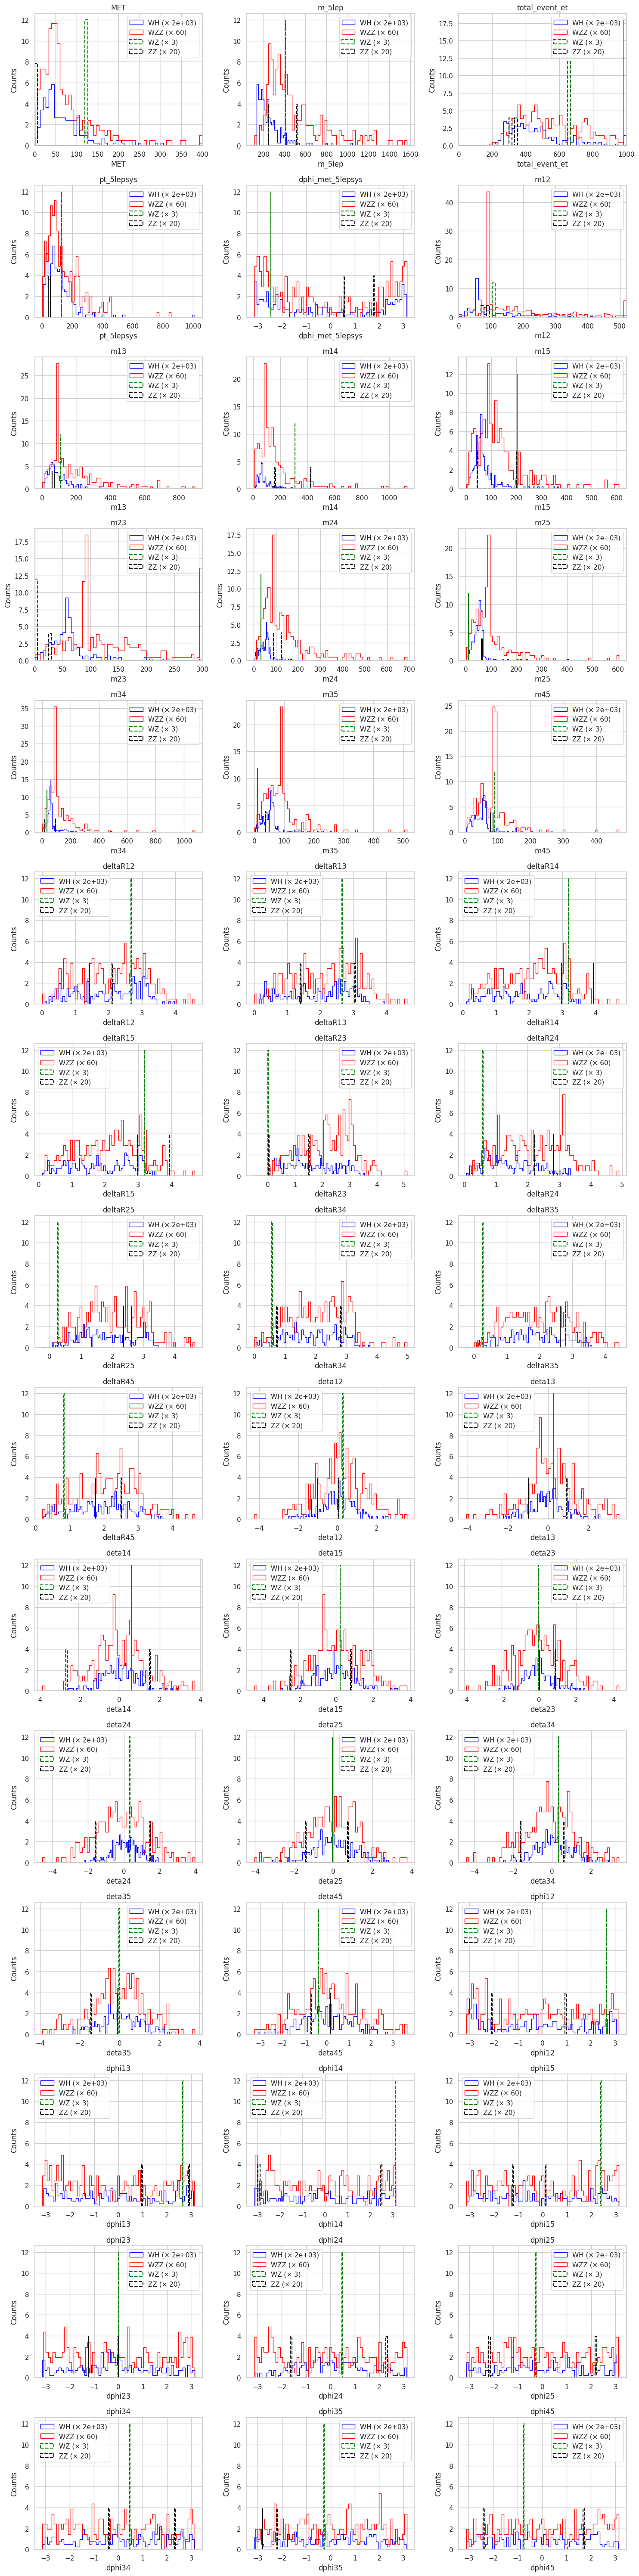

In [17]:

df = pd.concat(dfs, ignore_index=True)

label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

# Normalization factors and multiplicative factors from Part I
norm_factors = {
    "WH": 0.0001218 * 2000,
    "WZZ": 0.0081 * 60,
    "WZ": 4.0*3,
    "ZZ": 0.196 * 20
}

multiplicative_factors = {
    "WH": 2000,
    "WZZ": 60,
    "WZ": 3.0,
    "ZZ": 20
}
x_limits = {
    "MET": (0, 400),
    "m_3lep": (0, 500),
    "total_event_et": (0, 1000),
    "MT_lep_MET": (-20, 500),
    "pt_3lepsys": (0,520),
    "best_Z_mass_mu": (0, 250),
    "best_Z_mass_el": (0, 250),
    "best_Z_pt_mu": (0, 400),
    "best_Z_pt_el": (0, 400),
    "m12":(0,520), 
    "m23":(0,300), 
    "m31":(0,520), 
    #"Z_MET_dphi_mu":(), 
    "Z_MET_par_mu":(-250, 250), 
    "Z_MET_perp_mu":(-200, 200), 
    "Z_MET_ratio_mu": (0, 10), 
    "Z_MET_diff_mu":(-200, 250), 
    "Z_MET_recoil_mu": (0, 400),
    #"Z_MET_dphi_el": (), 
    "Z_MET_par_el":(-250,250), 
    "Z_MET_perp_el":(-200,200), 
    "Z_MET_ratio_el":(0,10), 
    "Z_MET_diff_el":(-200, 250), 
    "Z_MET_recoil_el":(0, 400),
    "del_phi_Z_lep_mu":(-5,5), 
    "del_phi_Z_lep_el":(-5,5)
}

features = ["MET", "m_5lep", "total_event_et",
          "pt_5lepsys", "dphi_met_5lepsys", "m12", "m13", "m14", "m15", "m23", "m24", "m25", "m34", "m35", "m45", 
          "deltaR12","deltaR13", "deltaR14", "deltaR15","deltaR23","deltaR24","deltaR25", "deltaR34", "deltaR35", "deltaR45",
          "deta12", "deta13","deta14","deta15", "deta23","deta24", "deta25","deta34", "deta35","deta45",
          "dphi12","dphi13", "dphi14", "dphi15","dphi23", "dphi24", "dphi25","dphi34", "dphi35", "dphi45"]

n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()


signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

for i, feature in enumerate(features):
    ax = axes[i]

    #bins for overflow
    if feature in x_limits:
        xmin, xmax = x_limits[feature]
        bins = np.linspace(xmin, xmax, 61)  # 50 bins
    else:
        #other features need a default bin
        bins = 65

    for label_val, label_name in label_map.items():
        subset = df[df["label"] == label_val][feature].dropna()

        #clipping to overflow bin range
        if feature in x_limits:
            subset = subset.clip(upper=x_limits[feature][1])

        weight = norm_factors[label_name]
        multiplier = multiplicative_factors[label_name]
        display_label = f"{label_name} (× {multiplier:.2g})"
        linestyle = '-' if label_val in signal_labels else '--'
        linewidth = 1 if label_val in signal_labels else 1.5

        ax.hist(subset,
                bins=bins,
                weights=np.full(len(subset), weight),
                label=display_label,
                color=colors[label_val],
                linewidth=linewidth,
                linestyle=linestyle,
                histtype='step')

    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()

    #xlim for plots
    if feature in x_limits:
        ax.set_xlim(x_limits[feature])

#hiding unused axes
for i in range(len(features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

##there's a crazy -999 peak for best z candidate mass plots, Q. does that make a difference in classification?
#WH (blue solid line)
#Doesn’t have a peak near 91 GeV — instead, there’s a broad structure at much lower invariant masses.
#This is because WH events in your sample probably don’t contain real Z -> lep lep decays most of the time.
#The “best Z candidate” here is being formed from random lepton pairs, so you get a broad distribution.
#If you want the best Z candidate as a feature without biasing the classifier, you should not cut on the 80–100 GeV “Z window” 
#— otherwise, you’re essentially pre-selecting Z-rich events and throwing away useful shape information that can help discriminate signal/background.

#The shape difference itself is a discriminating feature:

#WH has a broad, low-mass distribution.

#ZZ/WZ/WZZ have a narrow peak at ~91 GeV.

NameError: name 'signal_colors' is not defined

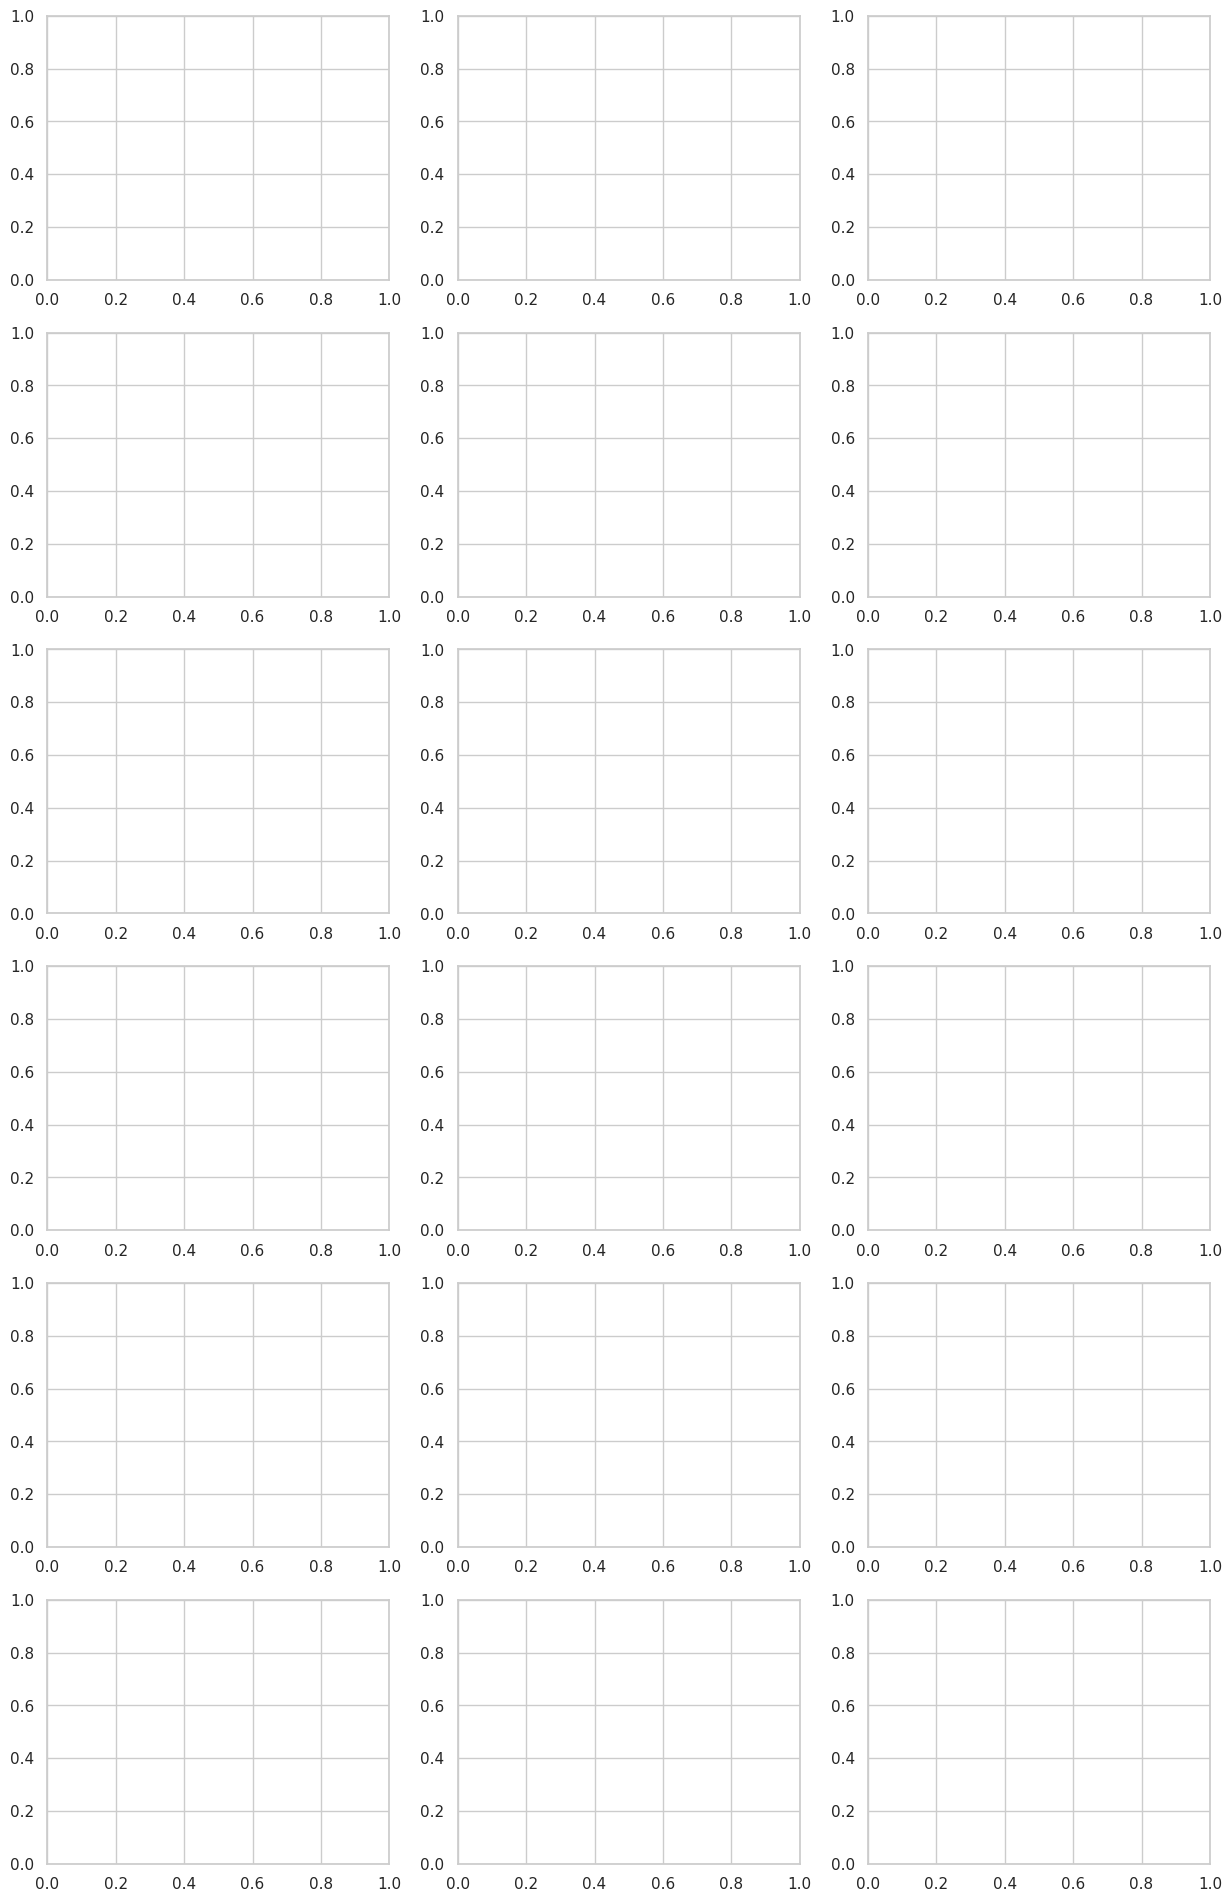

In [11]:
#Plotting right after the cuts are applied, for sanity

norm_factors = {
    "WH": 0.0001218 * 1000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196   #Why 4? New value used
}

multiplicative_factors = {
    "WH": 1000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()


for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()


for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized_aftercuts.png")
plt.show()

# Neural Network, Construction and Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np

#before
#df_all = pd.concat(dfs, ignore_index=True)



#removing some of the columns that make no difference
df_all = pd.concat(dfs, ignore_index=True)

# Drop unwanted columns
#df_all = df_all.drop(columns=['mu_eta_1', 'deta31', 'el_pt_2', 'mu_eta_0','el_phi_2','mu_phi_2','mu_phi_0','dphi23',
                             #'deta12', 'jet_phi_0','mu_phi_1','el_phi_1','el_phi_0', 'el_eta_1', 'deta23', 'sphericity', 'dphi31','dphi_met_3lepsys',
                             # 'dphi12', 'MET_Phi', 'el_eta_2', 'jet_phi_1', 'mu_eta_2', "del_phi_Z_MET_mu", "del_phi_Z_MET_el", "deltaR23",
                             # "el_eta_0", "jet_eta_0", "jet_eta_1" ])


feature_names = df_all.drop(columns=['label']).columns.to_numpy()

#separating out features and labels
X = df_all.drop(columns=['label']).values
y = df_all['label'].values

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

  #two step split
#Train + temp (validation+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42, shuffle=True    #(shuffle=True) 
)

#Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42, shuffle=True
)




2025-09-19 20:31:49.491836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758331909.502359 2168577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758331909.505442 2168577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758331909.514630 2168577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758331909.514639 2168577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758331909.514641 2168577 computation_placer.cc:177] computation placer alr

Features shape: (497, 99)
Labels shape: (497,)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [19]:
#scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

NameError: name 'X_train' is not defined

In [12]:
print(X_train)
print(X_test)
print(X_val)

[[ 61.44391632  77.4306488   47.17694855 ...   1.90209541   2.3163555
    2.14262724]
 [ 92.30565643  58.53802872   3.         ...   3.05617857   0.63798135
    0.65460976]
 [ 30.73675537  95.64044952   3.         ...   1.14843275   1.8924603
    2.7938294 ]
 ...
 [ 33.82551956  72.59438324   3.         ...   0.71246468   3.12846494
    3.84761115]
 [ 63.01309967   3.          55.48567963 ...   2.61624023   1.55461402
    1.8116447 ]
 [ 74.3121109  136.61091614   3.         ...   2.34016515   2.77981896
    2.44470959]]
[[ 64.3808136    3.          35.78285599 ...   2.45003529   3.86830159
    3.89057786]
 [  3.         103.3398819    3.         ...   1.66483782   2.82660622
    1.41926831]
 [  3.         104.41741943   3.         ...   0.47172663   2.59460141
    1.53146874]
 ...
 [ 84.41308594   3.          38.54662704 ...   3.30212009   2.01208682
    3.43614424]
 [ 51.39914703  77.24572754   3.         ...   2.36974181   2.77892107
    1.14140921]
 [ 19.14377022  31.89930344  13.07

Shuffle the data 2. Split the data to train test and validation set 3. Why you changed the X_train shape 4. Play a bit with the Denses and layers to see if see any differences 5. Early stopping , regularization batch normalization 6. You can search if sth like grid search exist for NN like for XGboost 7. Balancing the weight (class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train) make a bar plot to visualize the imbalance 5. The probability for each class

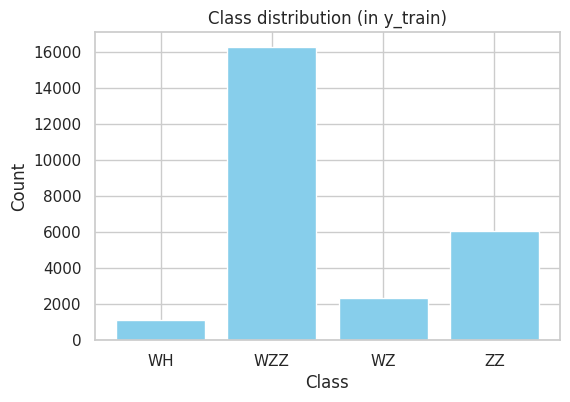

In [13]:
#Class contribution/Visualising the imbalance in classes

label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
unique_classes, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar([label_map[c] for c in unique_classes], counts, color='skyblue')
plt.xticks(unique_classes)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution (in y_train)")
plt.show()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

#computing class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
cw = dict(zip(np.unique(y_train), class_weights))

#identify the number of calsses directly
n_classes = len(np.unique(y))

#early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

#main model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=100,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_cat),
    class_weight=cw,               #using class weights and callbacks/early stopping now 
    callbacks=[early_stop],        
    verbose=1
)

#play with dense
#regularization/
#see if gridsearch exists
#X_train_scaled.shape[1]?
#minimization of learning rate

#make bar plot to visualize class imbalance before training. balance weights
#prediction for each class (bar plot), probabilities





Epoch 1/100


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-25 08:10:50.026428: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3496 - loss: 1.5329 - val_accuracy: 0.6015 - val_loss: 1.0011
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4771 - loss: 1.1084 - val_accuracy: 0.5886 - val_loss: 0.9656
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5138 - loss: 1.0423 - val_accuracy: 0.5857 - val_loss: 0.9709
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5152 - loss: 0.9975 - val_accuracy: 0.5859 - val_loss: 0.9644
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5409 - loss: 0.9572 - val_accuracy: 0.5870 - val_loss: 0.9626
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5502 - loss: 0.9385 - val_accuracy: 0.6076 - val_loss: 0.9351
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5489 - loss: 0.9272 - val_accuracy: 0.6154 - val_loss: 0.9244
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5750 - loss: 0.9119 - val_accuracy: 0.6058

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
0
0

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.81      0.54       242
           1       0.90      0.59      0.71      3487
           2       0.27      0.62      0.38       499
           3       0.68      0.86      0.76      1296

    accuracy                           0.66      5524
   macro avg       0.56      0.72      0.60      5524
weighted avg       0.77      0.66      0.69      5524

Confusion Matrix:
 [[ 196   17   13   16]
 [ 257 2054  726  450]
 [  14  115  307   63]
 [  20   84   78 1114]]


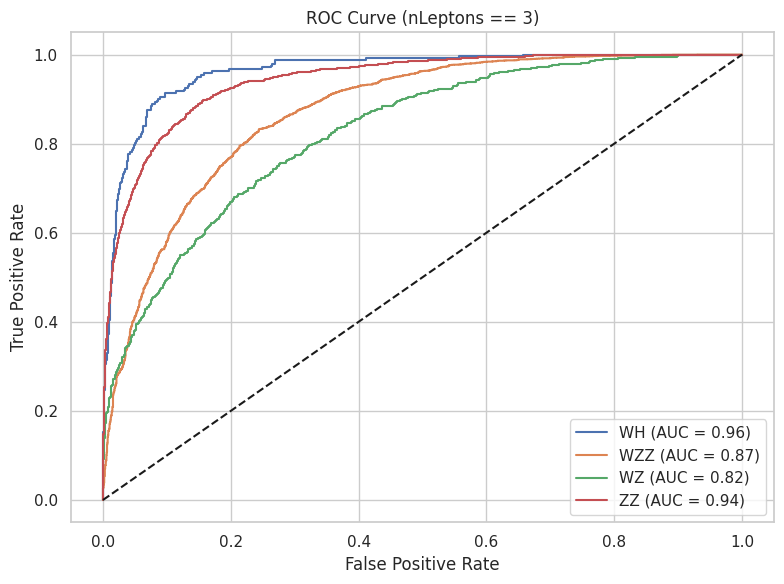

In [15]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Model Evaluation
test_preds = model.predict(X_test_scaled)
test_preds_label = np.argmax(test_preds, axis=1)

print(np.isnan(X_test).sum())
print(np.isnan(test_preds).sum())

print("\nClassification Report:\n", classification_report(y_test, test_preds_label))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds_label))
# Define your class names in the order of their numeric labels
class_names = ["WH", "WZZ", "WZ", "ZZ"]

#ROC for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], test_preds[:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], test_preds[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (nLeptons == 3)")
plt.legend()
plt.tight_layout()
plt.savefig("3Lep_ROC.png", dpi=300, bbox_inches='tight')
plt.show()

#make confusion matrix 


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step


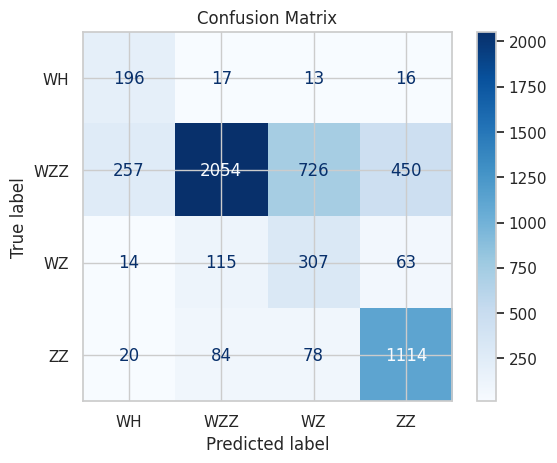

In [16]:
class_names = ["WH", "WZZ", "WZ", "ZZ"]


#Predictions (probabilities -> predicted class index)
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

#Converting one-hot y_test back to class indices
y_true_classes = np.argmax(y_test_cat, axis=1)

#confusion matrix main comp
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer display
plt.title("Confusion Matrix")
plt.show()

#added features and WZZ, WZ overlap increased

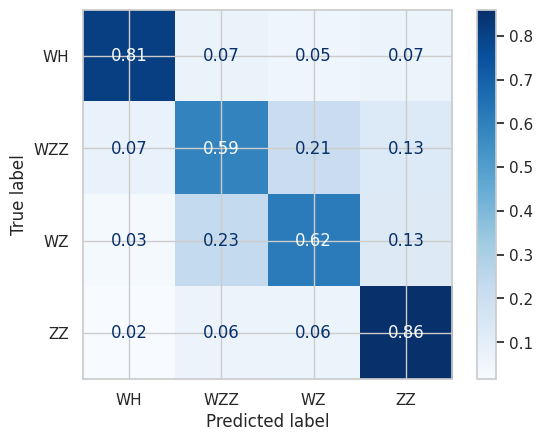

In [17]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2f')


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


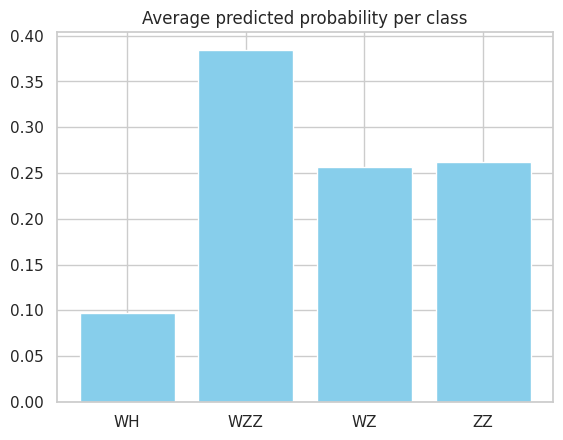

In [18]:
#Predicted probability per Class

label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}

y_pred_proba = model.predict(X_val_scaled)
avg_probs = np.mean(y_pred_proba, axis=0)
plt.bar([label_map[c] for c in unique_classes], avg_probs, color='skyblue')
plt.title("Average predicted probability per class")
plt.show()

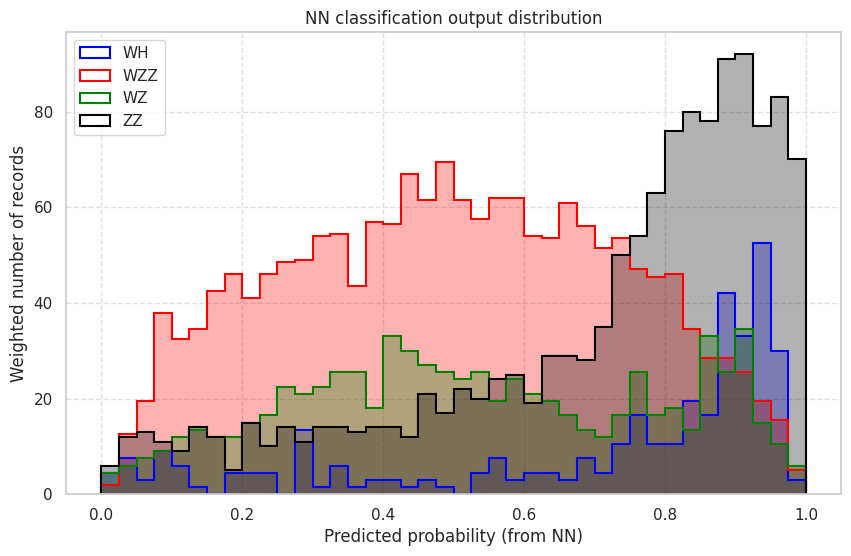

In [19]:
class_labels = ["WH", "WZZ", "WZ", "ZZ"]
colors = ["blue", "red", "green", "black"]

multiplication_factors = {
    "WH": 1.5,     
    "WZZ": 0.5,    
    "WZ": 1.5,     
    "ZZ": 1      
}

plt.figure(figsize=(10, 6))

for i, label in enumerate(class_labels):
    probs = y_pred_probs[y_test == i, i]
    weights = np.ones_like(probs) * multiplication_factors[label]

    #filled hist
    plt.hist(probs, bins=40, range=(0,1),
             histtype="stepfilled", alpha=0.3,
             color=colors[i], weights=weights)

    #outline
    plt.hist(probs, bins=40, range=(0,1),
             histtype="step", linewidth=1.5,
             color=colors[i], label=label, weights=weights)

plt.xlabel("Predicted probability (from NN)")
plt.ylabel("Weighted number of records")
plt.title("NN classification output distribution")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


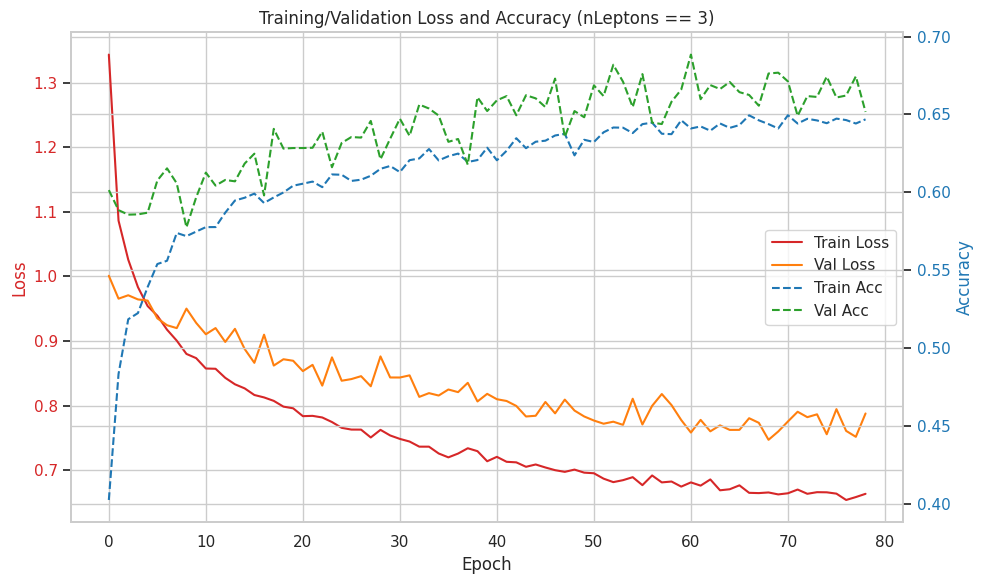

In [20]:
import matplotlib.pyplot as plt

#main fig and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loss (left y-axis)
ax1.plot(history.history['loss'], label='Train Loss', color='tab:red')
ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:orange')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Acc', color='tab:blue', linestyle='--')
ax2.plot(history.history['val_accuracy'], label='Val Acc', color='tab:green', linestyle='--')
ax2.set_ylabel("Accuracy", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

#combining legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.title("Training/Validation Loss and Accuracy (nLeptons == 3)")
plt.grid(True)
plt.tight_layout()
plt.savefig("3Lep_LossAcc.png", dpi=300, bbox_inches='tight')
plt.show()

#overfitting! What's not right?

/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 201it [00:19,  8.61it/s]                         
/tmp/ipykernel_3660289/715720722.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


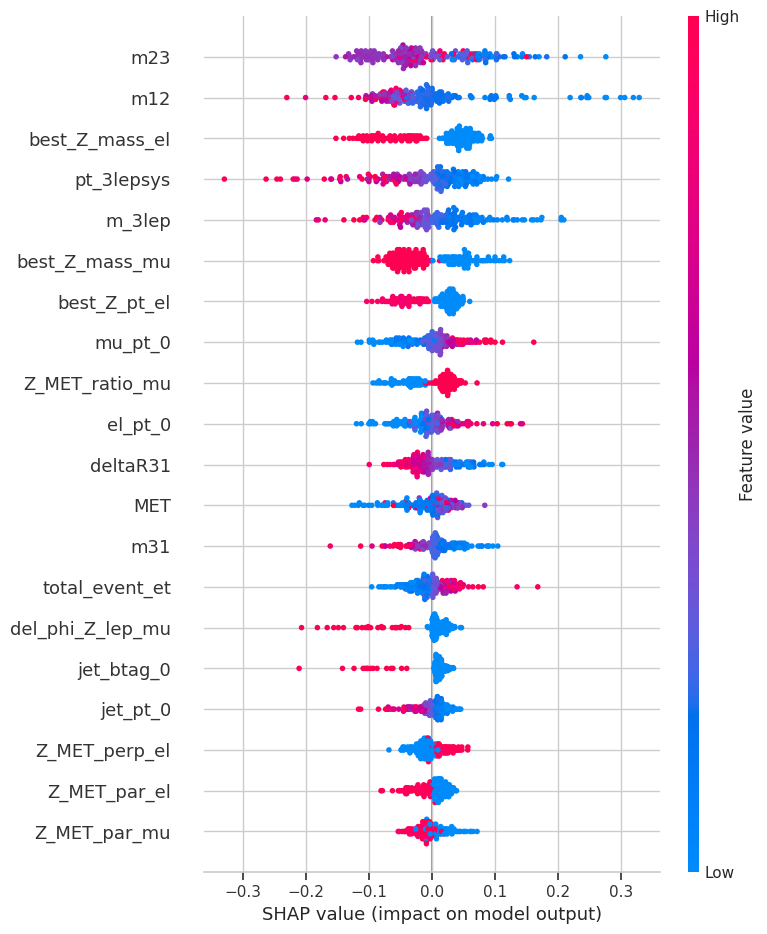

In [54]:
import shap
import numpy as np

X_explain = X_train_scaled[:500]
explainer = shap.Explainer(model, X_explain)

shap_values = explainer(X_test_scaled[:200])

shap.summary_plot(
    shap_values.values[..., 0],
    X_test_scaled[:200],
    feature_names=feature_names
)
plt.tight_layout()
plt.savefig("3Lep_SHAP_summary_new.png", dpi=300)
plt.close()


PermutationExplainer explainer: 201it [00:10,  1.56it/s]                         


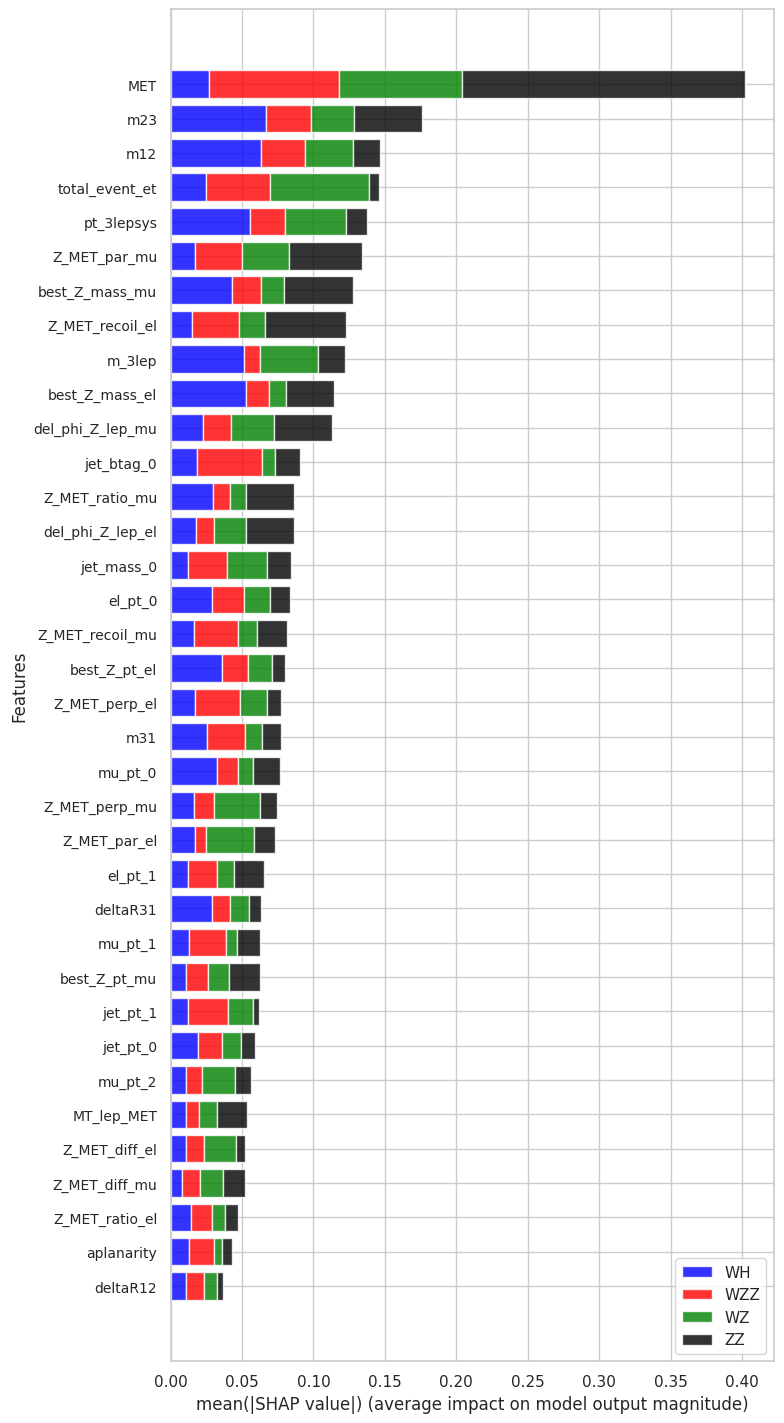

In [55]:


# Take subset for SHAP to speed up
X_explain = X_train_scaled[:500]
explainer = shap.Explainer(model, X_explain)
shap_values = explainer(X_test_scaled[:200])

# shap_values.values has shape (n_samples, n_features, n_classes)
vals = np.abs(shap_values.values).mean(axis=0)  # mean(|SHAP|) over samples → shape (n_features, n_classes)

# Prepare feature importances
feature_importance = vals  # (n_features, n_classes)
features = feature_names

# Class labels (adjust to your case)
class_labels = ["WH", "WZZ", "WZ", "ZZ"]
colors = ["blue", "red", "green", "black"]

# Sort features by total importance
sorted_idx = np.argsort(feature_importance.sum(axis=1))[::-1]
features_sorted = [features[i] for i in sorted_idx]
importance_sorted = feature_importance[sorted_idx]

# Adjust figure height based on number of features
fig_height = max(6, 0.4 * len(features_sorted))  # 0.4 inch per feature, minimum 6
fig, ax = plt.subplots(figsize=(8, fig_height))

bottom = np.zeros(len(features_sorted))
for cls_idx, (cls_label, color) in enumerate(zip(class_labels, colors)):
    ax.barh(
        features_sorted,
        importance_sorted[:, cls_idx],
        left=bottom,
        label=cls_label,
        color=color,
        alpha=0.8
    )
    bottom += importance_sorted[:, cls_idx]

ax.set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
ax.set_ylabel("Features")
ax.legend()

# Flip y-axis so most important features are at the top
ax.invert_yaxis()

# Reduce font size for feature names
ax.tick_params(axis="y", labelsize=10)  # smaller font on y-axis labels
plt.tight_layout()

plt.savefig("3Lep_SHAP_stacked.png")
plt.show()



In [45]:

def asimov_Z(s, b, eps=1e-12):
    s = float(s); b = float(b)
    if s <= 0:     
        return 0.0    #asimov, no
    if b <= 0:
        return np.sqrt(2.0*s)  # conservative limit for b→0
    return np.sqrt(2.0 * ((s + b) * np.log(1.0 + s / (b + eps)) - s))

def asimov_ovr_from_softmax(
    y_true,             # integer class labels, shape (N,)
    y_pred_proba,       # softmax probs, shape (N, C)
    class_names,        # list in index order
    xsec_fb,            # dict: class_name -> cross section 
    lumi_fb             # float luminosity in
):
    """
    One-vs-rest Asimov Z for a multi-class classifier.
    Uses argmax(y_pred_proba) as the selection for each class.
    """
    y_true = np.asarray(y_true)
    y_pred = np.argmax(y_pred_proba, axis=1)
    n_classes = len(class_names)

    # sanity checks
    assert y_pred_proba.shape[1] == n_classes, "class_names must match model outputs"
    for cls in class_names:
        assert cls in xsec_fb, f"Missing cross section for {cls}"

    # per-class totals
    N_per_cls = {i: int(np.sum(y_true == i)) for i in range(n_classes)}

    # build confusion-style counts:
    # selected_as[c][i] = # of true class i predicted as c
    selected_as = {
    c: {i: int(np.sum((y_true == i) & (y_pred == c))) for i in range(n_classes)}
    for c in range(n_classes)
}

    # compute efficiencies and yields, then Z
    Z = {}
    for c, cname in enumerate(class_names):
        # signal efficiency ε_s (fraction of true-c predicted as c)
        Nc = N_per_cls[c]
        tp = selected_as[c][c]
        eps_s = tp / Nc if Nc > 0 else 0.0

        # background efficiencies ε_b(k) per background class k ≠ c
        eps_b_per_k = {}
        for k in range(n_classes):
            if k == c: 
                continue
            Nk = N_per_cls[k]
            fp_k = selected_as[c][k]  # true k predicted as c
            eps_b_per_k[k] = fp_k / Nk if Nk > 0 else 0.0

        # expected yields from σ × L × ε
        S = xsec_fb[cname] * lumi_fb * eps_s
        B = 0.0
        for k, kname in enumerate(class_names):
            if k == c:
                continue
            B += xsec_fb[kname] * lumi_fb * eps_b_per_k[k]

        Z[cname] = asimov_Z(S, B)
        
        print(f"\nClass {cname}")
        print(f"  Nc = {Nc}, tp = {tp}, eps_s = {eps_s:.3f}")
        print(f"  eps_b_per_k = {eps_b_per_k}")
        print(f"  S = {S:.2f}, B = {B:.2f}")
    return Z



In [46]:
print("y_test shape:", y_test.shape)
print("y_pred_proba shape:", y_pred_proba.shape)
n = min(len(y_test), len(y_pred_proba))
y_test = y_test[:n]
y_pred_proba = y_pred_proba[:n]
print("y_test shape:", y_test.shape)
print("y_pred_proba shape:", y_pred_proba.shape)


y_test shape: (5523,)
y_pred_proba shape: (5523, 4)
y_test shape: (5523,)
y_pred_proba shape: (5523, 4)


In [47]:
class_names = ["WH", "WZZ", "WZ", "ZZ"]

xsec_fb = {
    "WH": 0.379,         # fb
    "WZZ": 2.7,          # fb
    "WZ": 1250.0,        # fb (1.25 pb)
    "ZZ": 61.56,         # fb (0.06156 pb)
}
lumi_fb = 320.0



# y_test: integer labels in 0..3 aligned with class_names order
# y_pred_proba: model.predict(X_test_scaled)
Z_asimov = asimov_ovr_from_softmax(y_test, y_pred_proba, class_names, xsec_fb, lumi_fb)
print(Z_asimov)



Class WH
  Nc = 242, tp = 15, eps_s = 0.062
  eps_b_per_k = {1: 0.09466437177280551, 2: 0.09619238476953908, 3: 0.08950617283950617}
  S = 7.52, B = 40321.94

Class WZZ
  Nc = 3486, tp = 1470, eps_s = 0.422
  eps_b_per_k = {0: 0.47107438016528924, 2: 0.4408817635270541, 3: 0.4359567901234568}
  S = 364.34, B = 184997.84

Class WZ
  Nc = 499, tp = 88, eps_s = 0.176
  eps_b_per_k = {0: 0.18181818181818182, 1: 0.20567986230636834, 3: 0.19058641975308643}
  S = 70541.08, B = 3954.16

Class ZZ
  Nc = 1296, tp = 368, eps_s = 0.284
  eps_b_per_k = {0: 0.28512396694214875, 1: 0.27796901893287435, 2: 0.2865731462925852}
  S = 5593.60, B = 114904.00
{'WH': 0.037435260386686896, 'WZZ': 0.8467942713196642, 'WZ': 544.379501679612, 'ZZ': 16.370275942449673}


In [48]:
def compute_significance_signals_only(results, yields, lumi=320.0):
    """
    Compute Asimov significance only for  signals,
    treating rest always as backgrounds.
    
    results: dict with class efficiencies (like your eps_s, eps_b_per_k)
    yields: dict with cross sections {class: xsec_fb}
    lumi: luminosity in fb^-1
    """
    from math import sqrt, log
    
    def asimov(S, B):
        if S <= 0 or B <= 0:
            return 0.0
        return sqrt(2 * ((S + B) * log(1 + S / B) - S))

    significances = {}

    for signal_class in ["WH", "WZZ"]:
        S = results[signal_class]["eps_s"] * yields[signal_class] * lumi
        B = 0.0
        for bkg_class in ["WH", "WZZ", "WZ", "ZZ"]:
            if bkg_class == signal_class:
                continue
            eps_b = results[signal_class]["eps_b_per_k"].get(
                list(yields.keys()).index(bkg_class), 0.0
            )
            B += eps_b * yields[bkg_class] * lumi
        significances[signal_class] = asimov(S, B)

    return significances


In [50]:
yields = {
    "WH": 0.379,   # fb
    "WZZ": 6.33,
    "WZ": 1250.0,
    "ZZ": 62.0
}

# Using dict structure
results = {
    "WH": {
        "eps_s": 0.062,
        "eps_b_per_k": {1: 0.094664, 2: 0.096192, 3: 0.089506}
    },
    "WZZ": {
        "eps_s": 0.422,
        "eps_b_per_k": {0: 0.471074, 2: 0.440882, 3: 0.435957}
    },
    "WZ": {
        "eps_s": 0.176,
        "eps_b_per_k": {0: 0.181818, 1: 0.205680, 3: 0.190586}
    },
    "ZZ": {
        "eps_s": 0.284,
        "eps_b_per_k": {0: 0.285124, 1: 0.277969, 2: 0.286573}
    }
}

print(compute_significance_signals_only(results, yields))


{'WH': 0.037388538500964213, 'WZZ': 1.9855317376561132}


In [8]:
#remove some features maybe based on size of colors for different classes. what to give priority to.

# How Shape Differences in Feature Plots Relate to Multi-Class Classification Performance
1. Peaks and Shape Differences

If two classes have well-separated peaks (e.g., WH events peak at a higher invariant mass than ZZ), then this feature alone carries strong discriminating power.

If their shapes overlap heavily, the feature is less useful by itself.

Larger differences in position/width of peaks → more useful for classification.

2. Multi-Class Case

In multi-class classification (e.g., WH, WZZ, WZ, ZZ):

Some features clearly separate one class from the rest.

Some distinguish pairs of classes.

Others contribute little on their own but still add information when combined with other features.

3. Correlations Matter

A feature that looks weak in 1D can become powerful in combination with others.

Example:

mZ
m
Z
	​

 candidate alone looks similar for WZ and ZZ.

Adding lepton 
pT
p
T
	​

 or 
ΔR
ΔR between jets makes the classes separable in higher-dimensional space.

This is why neural networks and boosted trees outperform simple cut-based methods.

4. Performance Connection

Features with large shape differences → higher importance in the model (entropy/Gini reduction in XGBoost, large SHAP values).

Features with overlapping shapes → lower importance (unless correlations save them).

If all features overlap strongly → classifier struggles (low accuracy, flat ROC curves).

If a few features stand out → classifier performance improves significantly.

5. Physics Angle

The shifted Z candidate peak in WH vs. ZZ/WZ isn’t an artifact — it’s a real physics handle.

It reflects different kinematics of the Z boson depending on whether it comes from Higgs → ZZ or from direct WZ/ZZ production.

Classifiers exploit such differences to separate processes.

Other physics handles:

MET distributions

Jet multiplicities

Angular separations